In [313]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [314]:
import pandas as pd
import numpy as np
from scipy.optimize import root_scalar
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import brentq
import re
from scipy.interpolate import interp1d




In [315]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Load the provided CSV file
file_path = "/content/drive/MyDrive/APM 466 A1/APM466 Data (1).csv"
df = pd.read_csv(file_path, parse_dates=['Issue Date', 'Maturity Date'])

In [316]:
# 'Coupon' column to numeric by stripping the '%' sign and converting to float
df['Coupon'] = df['Coupon'].astype(str).str.rstrip('%').astype(float)

# range
start_dt = datetime(2025, 1, 1)
end_dt = datetime(2030, 1, 1)

# filter maturities between 2025-01-01 and 2030-01-01
mask = (df['Maturity Date'] >= start_dt) & (df['Maturity Date'] < end_dt)
df_filtered = df.loc[mask].copy()

# filter bonds with coupons between 0.25% and 4.0%
df_filtered = df_filtered[df_filtered['Coupon'].between(0.25, 4.00)]

# define semi-annual target maturity dates (March 1 and September 1 from 2025 to 2029)
target_maturities = []
t = datetime(2025, 3, 1)
while t < datetime(2030, 1, 1):
    target_maturities.append(t)
    t += relativedelta(months=6)

# select bonds closest to each target maturity date
chosen_isins = []
for target_date in target_maturities:
    df_filtered['days_diff'] = (df_filtered['Maturity Date'] - target_date).abs().dt.days
    best_idx = df_filtered['days_diff'].idxmin()
    chosen_isins.append(df_filtered.loc[best_idx, 'ISIN'])
    df_filtered.drop(index=best_idx, inplace=True)
chosen_isins


['CA135087K528',
 'CA135087K940',
 'CA135087L518',
 'CA135087L930',
 'CA135087M847',
 'CA135087N837',
 'CA135087P576',
 'CA135087Q491',
 'CA135087Q988',
 'CA135087R895']

In [317]:
selected_isins = ['CA135087K528', 'CA135087K940', 'CA135087L518', 'CA135087L930', 'CA135087M847', 'CA135087N837', 'CA135087P576', 'CA135087Q491', 'CA135087Q988', 'CA135087R895']
df_selected = df[df['ISIN'].isin(selected_isins)]

# Save the filtered DataFrame to a CSV file
df_selected.to_csv('selected_bonds.csv', index=False)

In [318]:
selected_bonds_info_with_coupon = df[df['ISIN'].isin(chosen_isins)][['ISIN', 'Issue Date', 'Maturity Date', 'Coupon']]

# Display the information
print(selected_bonds_info_with_coupon)

            ISIN Issue Date Maturity Date  Coupon
0   CA135087Q491 2023-04-21    2028-09-01    3.25
2   CA135087P576 2022-10-21    2028-03-01    3.50
12  CA135087R895 2024-04-08    2029-09-01    3.50
16  CA135087Q988 2023-10-13    2029-03-01    4.00
22  CA135087K528 2019-10-11    2025-03-01    1.25
23  CA135087K940 2020-04-03    2025-09-01    0.50
25  CA135087N837 2022-05-13    2027-09-01    2.75
28  CA135087L518 2020-10-09    2026-03-01    0.25
30  CA135087L930 2021-04-16    2026-09-01    1.00
40  CA135087M847 2021-10-15    2027-03-01    1.25


In [319]:
# Sort the DataFrame by 'Maturity Date'
df_selected_sorted = df_selected.sort_values(by='Maturity Date')

# Save the sorted DataFrame to a new CSV file
df_selected_sorted.to_csv('sorted.csv', index=False)


In [320]:
import pandas as pd

# Load the sorted CSV file
file_path = "sorted.csv"
sorted_bonds = pd.read_csv(file_path, parse_dates=['Maturity Date'])

# define specific maturity dates
select_maturity_dates = pd.to_datetime([
    "3/1/2025", "9/1/2025", "3/1/2026", "9/1/2026",
    "3/1/2027", "9/1/2027", "3/1/2028", "9/1/2028",
    "3/1/2029", "9/1/2029", "3/1/2030"
], format='%m/%d/%Y')

# filter and sort data
filtered_df = sorted_bonds[sorted_bonds["Maturity Date"].isin(select_maturity_dates)]
filtered_df = filtered_df.sort_values(by="Maturity Date").reset_index(drop=True)

# convert Coupon to decimal
filtered_df["Coupon"] /= 100

# calculate dirty prices
days_to_last_coupon = 30
date_indices = [6, 7, 8, 9, 10, 13, 14, 15, 16, 17]
date_cols = [f'2025-01-{i:02}' for i in date_indices if f'2025-01-{i:02}' in filtered_df.columns]
accrued_interest = (filtered_df["Coupon"] * 100) * (days_to_last_coupon / 365)
dirty_prices_df = filtered_df[["ISIN", "Coupon", "Maturity Date"]].copy()

for col in date_cols:
    dirty_prices_df[f"{col} Dirty Price"] = filtered_df[col] + accrued_interest

output_path = "dirty_prices.csv"
dirty_prices_df.to_csv(output_path, index=False)


In [321]:
file_path = "dirty_prices.csv"
bonds = pd.read_csv(file_path)
bonds['Maturity Date'] = pd.to_datetime(bonds['Maturity Date'])
bonds['Coupon'] = pd.to_numeric(bonds['Coupon'], errors='coerce')

price_cols = [c for c in bonds.columns if "Dirty Price" in c]


def ytm_function(y, dirty_price, coupon_per_period, redemption_value, t_values):
    """
    Bond pricing function for yield to maturity using continuous discounting.

    P = sum_{n=1}^{N} (coupon_per_period) * exp(-y * t_n) + redemption_value * exp(-y * T_final)

    where:
        y                = continuous yield
        dirty_price      = observed bond price (dirty)
        coupon_per_period= single coupon payment (for each period)
        redemption_value = final redemption (usually 100 + last coupon if you prefer)
        t_values         = array of times (in years) when each coupon is paid
    """
    pv_of_coupons = sum([coupon_per_period * np.exp(-y * t) for t in t_values])
    pv_of_redemption = redemption_value * np.exp(-y * t_values[-1]) if len(t_values) > 0 else 0
    model_price = pv_of_coupons + pv_of_redemption
    return dirty_price - model_price


result_rows = []

for i, row in bonds.iterrows():
    isin           = row['ISIN']
    maturity_date  = row['Maturity Date']
    annual_coupon  = row['Coupon']
    coupon_per_period = annual_coupon * 100 / 2
    redemption_value = 100
    row_dict = {
        'ISIN': isin,
        'Maturity Date': maturity_date.strftime('%Y-%m-%d')
    }

    for col in price_cols:
        date_str = col.replace(" Dirty Price", "")
        valuation_date = pd.to_datetime(date_str)

        dirty_price = row[col]
        if pd.isna(dirty_price):
            row_dict[date_str + " YTM"] = np.nan
            continue
        day_count = (maturity_date - valuation_date).days
        if day_count <= 0:
            row_dict[date_str + " YTM"] = np.nan
            continue
        time_to_maturity_years = day_count / 365.0
        num_periods = int(np.floor(time_to_maturity_years * 2))
        if num_periods < 1:
            t_values = [time_to_maturity_years]
        else:
            t_values = [0.5 * i for i in range(1, num_periods+1)]
            last_cash_flow_time = t_values[-1]
            if time_to_maturity_years > last_cash_flow_time:
                t_values[-1] = time_to_maturity_years

        try:
            sol = brentq(
                ytm_function,
                1e-8,
                1.0,
                args=(dirty_price, coupon_per_period, redemption_value, t_values),
                maxiter=1000
            )
            ytm_percent = sol * 100.0
            row_dict[date_str + " YTM"] = ytm_percent
        except ValueError:
            row_dict[date_str + " YTM"] = np.nan

    result_rows.append(row_dict)

results_df = pd.DataFrame(result_rows)

results_df.to_csv("bond_ytms.csv", index=False)
print("Wrote YTM results to bond_ytms.csv.")


Wrote YTM results to bond_ytms.csv.


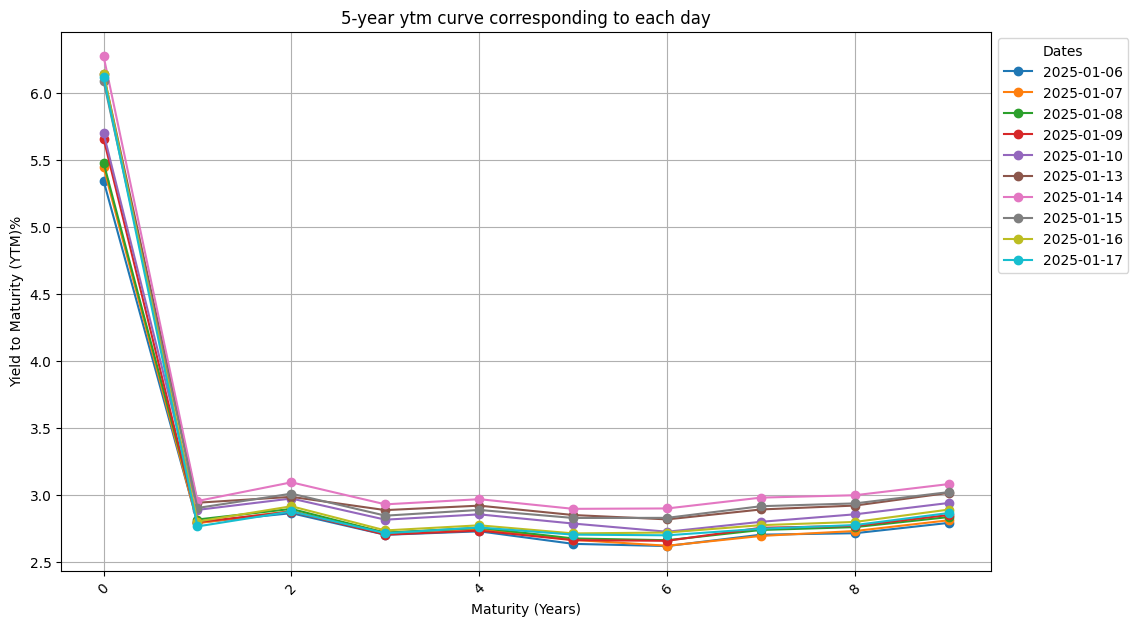

In [322]:
ytm_df = pd.read_csv("bond_ytms.csv")
plt.figure(figsize=(12, 7))
key_dates = pd.to_datetime([
    "2025-01-06", "2025-01-07", "2025-01-08", "2025-01-09", "2025-01-10",
    "2025-01-13", "2025-01-14", "2025-01-15", "2025-01-16", "2025-01-17"
])

for i, col in enumerate(ytm_df.columns[2:]):
    plt.plot(ytm_df.index, ytm_df[col], marker='o', linestyle='-', label=key_dates[i].strftime('%Y-%m-%d'))

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (YTM)%")
plt.title("5-year ytm curve corresponding to each day")
plt.xticks(rotation=45)
plt.legend(title="Dates", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)

plt.show()


In [323]:
file_path = "dirty_prices.csv"
df = pd.read_csv(file_path)
df["Maturity Date"] = pd.to_datetime(df["Maturity Date"], format="%Y-%m-%d")
price_cols = [col for col in df.columns if "Dirty Price" in col]

def time_to_maturity(valuation_date, maturity_date):
    return max((maturity_date - valuation_date).days / 365.0, 0.0)

def semiannual_periods(valuation_date, maturity_date):
    return int(round(time_to_maturity(valuation_date, maturity_date) * 2))

def coupon_per_period(annual_coupon):
    return annual_coupon * 100.0 / 2

def theoretical_price(n, known_spots, c):
    def price_function(r_n):
        pv = sum(c / ((1 + known_spots[k])**k) for k in range(1, n))
        pv += (c + 100.0) / ((1 + r_n)**n)
        return pv
    return price_function

def solve_for_spot(observed_price, n, known_spots, c, tol=1e-9, max_iter=50):
    price_fn = theoretical_price(n, known_spots, c)
    low, high = 0.0, 0.5
    for _ in range(max_iter):
        mid = (low + high) / 2
        if abs(price_fn(mid) - observed_price) < tol:
            return mid
        if (price_fn(low) - observed_price) * (price_fn(mid) - observed_price) < 0:
            high = mid
        else:
            low = mid
    return (low + high) / 2

spot_results = {}

for col in price_cols:
    date_str = col.replace(" Dirty Price", "")
    valuation_date = pd.to_datetime(date_str, errors="coerce")
    if pd.isnull(valuation_date):
        continue

    bond_info = [
        (semiannual_periods(valuation_date, row["Maturity Date"]), row[col], coupon_per_period(row["Coupon"]))
        for _, row in df.iterrows()
        if not pd.isna(row[col]) and 1 <= semiannual_periods(valuation_date, row["Maturity Date"]) <= 10
    ]

    bond_info.sort()
    known_spots = {}
    spot_rates = [np.nan] * 10

    for n, price, c in bond_info:
        if n == 1:
            known_spots[1] = (c + 100.0) / price - 1.0
            spot_rates[0] = known_spots[1]
        elif all(k in known_spots for k in range(1, n)):
            known_spots[n] = solve_for_spot(price, n, known_spots, c)
            spot_rates[n-1] = known_spots[n]

    spot_results[date_str] = spot_rates

Saved annualized spot rates to 'bootstrapped_spot_rates.csv'.


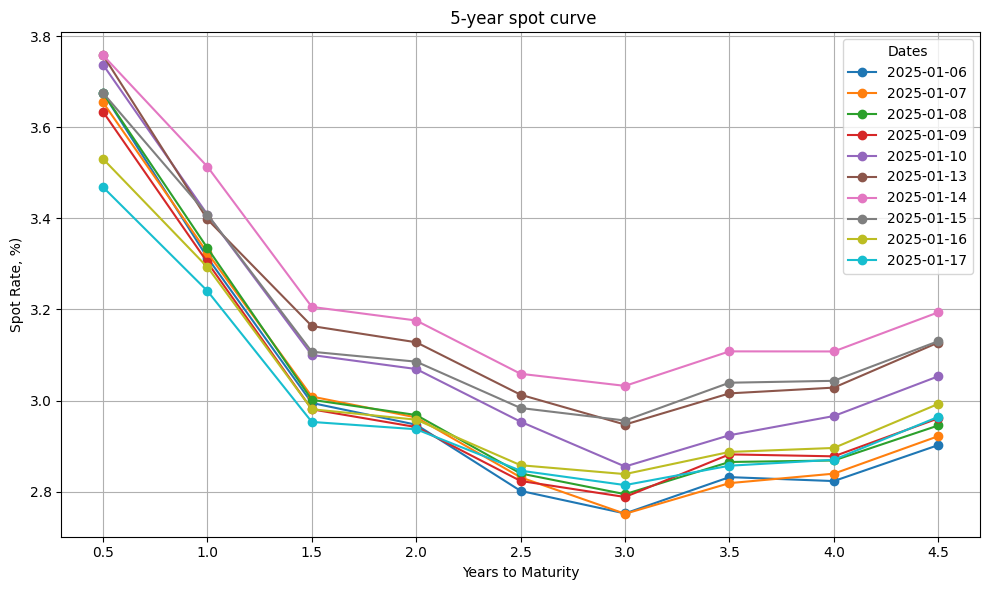

In [324]:
spot_df = pd.DataFrame.from_dict(spot_results, orient='index', columns=[f"Spot_{6*m}m" for m in range(1, MAX_PERIODS+1)])
spot_df.index.name = "Date"
spot_df = spot_df * 2 * 100
spot_df.to_csv("bootstrapped_spot_rates.csv")
print("Saved annualized spot rates to 'bootstrapped_spot_rates.csv'.")


plt.figure(figsize=(10, 6))
for date_str, row in spot_df.iterrows():
    x = np.arange(1, 10+1) / 2.0
    y = row.values
    plt.plot(x[~np.isnan(y)], y[~np.isnan(y)], marker='o', label=date_str)

plt.title(" 5-year spot curve")
plt.xlabel("Years to Maturity")
plt.ylabel("Spot Rate, %)")
plt.grid(True)
plt.legend(title="Dates", loc="best")
plt.tight_layout()
plt.show()

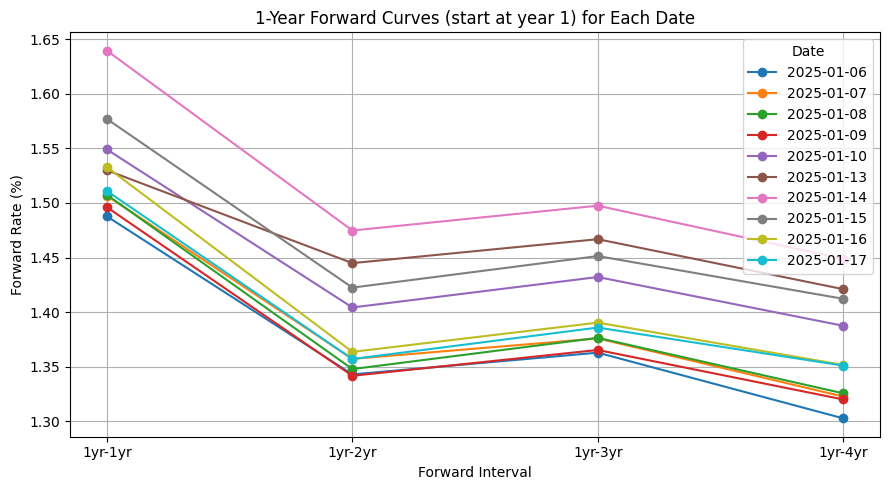

In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("bootstrapped_spot_rates.csv", index_col=0)


def one_year_forward(s1, sN, N):
    """
    Computes the 1-year forward rate from year 1 to year N, given:
      s1 = 1-year spot rate (decimal, semiannual compounding)
      sN = N-year spot rate (decimal, semiannual compounding)
      N  = integer (2..5) for the final maturity
    Using the standard formula for semiannual compounding:

        f(1->N) = [ (1 + sN/2)^(2*N) / (1 + s1/2)^(2*1) ]^(1 / [2*(N-1)]) - 1

    Returns decimal forward rate (e.g. 0.03 = 3%).
    """
    top = (1 + sN/2)**(2*N)
    bot = (1 + s1/2)**(2*1)
    exponent = 1.0 / (2.0*(N - 1))
    return top**exponent / bot**exponent - 1.0

def compute_1yr_forwards_from_row(row):
    """
    (Docstring updated to reflect the actual column names)
    Given a single row with columns:
      Spot_6m = 6-month spot,
      Spot_12m = 12-month spot,
      Spot_18m = 18-month spot,
      Spot_24m = 24-month spot,
      Spot_30m = 30-month spot,
    return a Series of the 4 forward rates:
      f(1->2), f(1->3), f(1->4), f(1->5).
    """
    s1 = row["Spot_6m"]
    s2 = row["Spot_12m"]
    s3 = row["Spot_18m"]
    s4 = row["Spot_24m"]
    s5 = row["Spot_30m"]

    f12 = one_year_forward(s1, s2, 2)
    f13 = one_year_forward(s1, s3, 3)
    f14 = one_year_forward(s1, s4, 4)
    f15 = one_year_forward(s1, s5, 5)

    return pd.Series([f12, f13, f14, f15],
                     index=["f(1->2)", "f(1->3)", "f(1->4)", "f(1->5)"])

fwd_df = df.apply(compute_1yr_forwards_from_row, axis=1)


fwd_df.to_csv("one_year_forward_rates.csv")


plt.figure(figsize=(9, 5))

x_positions = np.array([1,2,3,4])

for date_label in fwd_df.index:
    row = fwd_df.loc[date_label]
    y_values = row.values
    plt.plot(x_positions, y_values, marker='o', label=date_label)

plt.title("1-Year Forward Curves (start at year 1) for Each Date")
plt.xlabel("Forward Interval")
plt.ylabel("Forward Rate (%)")
plt.xticks(x_positions, ["1yr-1yr","1yr-2yr","1yr-3yr","1yr-4yr"])
plt.grid(True)
plt.legend(title="Date", loc="best")
plt.tight_layout()
plt.show()


In [326]:
import numpy as np
import pandas as pd

ytm_file_path = "bond_ytms.csv"
forward_file_path = "one_year_forward_rates.csv"

ytm_df = pd.read_csv(ytm_file_path)
forward_df = pd.read_csv(forward_file_path)

yields_data = ytm_df.iloc[:5, 2:].to_numpy()
log_returns_yields = np.log(yields_data[:, 1:] / yields_data[:, :-1])
cov_matrix_yields = np.cov(log_returns_yields, rowvar=True)

df_cov_matrix_yields = pd.DataFrame(
    cov_matrix_yields,
    index=[f'Yield {i+1}' for i in range(log_returns_yields.shape[0])],
    columns=[f'Yield {i+1}' for i in range(log_returns_yields.shape[0])]
)
forward_data = forward_df.iloc[:, 1:].to_numpy().T
log_returns_forward = np.log(forward_data[:, 1:] / forward_data[:, :-1])
cov_matrix_forward = np.cov(log_returns_forward, rowvar=True)



df_cov_matrix_forward = pd.DataFrame(
    cov_matrix_forward,
    index=[f'Forward {i+1}' for i in range(log_returns_forward.shape[0])],
    columns=[f'Forward {i+1}' for i in range(log_returns_forward.shape[0])]
)

eigenvalues_yields, eigenvectors_yields = np.linalg.eig(cov_matrix_yields)

df_eigenvalues_yields = pd.DataFrame(
    eigenvalues_yields, columns=["Eigenvalues"]
)
df_eigenvectors_yields = pd.DataFrame(
    eigenvectors_yields,
    index=[f'Yield {i+1}' for i in range(len(eigenvalues_yields))],
    columns=[f'EV {i+1}' for i in range(len(eigenvalues_yields))]
)

eigenvalues_forward, eigenvectors_forward = np.linalg.eig(cov_matrix_forward)


df_eigenvalues_forward = pd.DataFrame(
    eigenvalues_forward, columns=["Eigenvalues"]
)
df_eigenvectors_forward = pd.DataFrame(
    eigenvectors_forward,
    index=[f'Forward {i+1}' for i in range(len(eigenvalues_forward))],
    columns=[f'EV {i+1}' for i in range(len(eigenvalues_forward))]
)

# Print results
print("Covariance Matrix of Yield Log-Returns:")
print(df_cov_matrix_yields)

print("\nCovariance Matrix of Forward Rate Log-Returns:")
print(df_cov_matrix_forward)

print("\nEigenvalues of Yield Covariance Matrix:")
print(df_eigenvalues_yields)

print("\nEigenvectors of Yield Covariance Matrix:")
print(df_eigenvectors_yields)

print("\nEigenvalues of Forward Rate Covariance Matrix:")
print(df_eigenvalues_forward)

print("\nEigenvectors of Forward Rate Covariance Matrix:")
print(df_eigenvectors_forward)

# Interpretation of the largest eigenvalue and eigenvector
largest_eigenvalue_yields = eigenvalues_yields[0]
largest_eigenvector_yields = eigenvectors_yields[:, 0]

largest_eigenvalue_forward = eigenvalues_forward[0]
largest_eigenvector_forward = eigenvectors_forward[:, 0]

print("\nInterpretation:")
print(f"The largest eigenvalue for Yields is {largest_eigenvalue_yields:.6f}, which corresponds to the eigenvector:")
print(largest_eigenvector_yields)
print("This suggests that most yield changes move together in a similar proportion.")

print(f"\nThe largest eigenvalue for Forward Rates is {largest_eigenvalue_forward:.6f}, which corresponds to the eigenvector:")
print(largest_eigenvector_forward)
print("This suggests that forward rates tend to move in the same direction, indicating overall market expectations.")


Covariance Matrix of Yield Log-Returns:
          Yield 1   Yield 2   Yield 3   Yield 4   Yield 5
Yield 1  0.000811  0.000240  0.000221  0.000363  0.000320
Yield 2  0.000240  0.000408  0.000399  0.000484  0.000495
Yield 3  0.000221  0.000399  0.000558  0.000527  0.000543
Yield 4  0.000363  0.000484  0.000527  0.000628  0.000635
Yield 5  0.000320  0.000495  0.000543  0.000635  0.000647

Covariance Matrix of Forward Rate Log-Returns:
           Forward 1  Forward 2  Forward 3  Forward 4
Forward 1   0.001108   0.000684   0.000680   0.000649
Forward 2   0.000684   0.000825   0.000796   0.000783
Forward 3   0.000680   0.000796   0.000781   0.000770
Forward 4   0.000649   0.000783   0.000770   0.000766

Eigenvalues of Yield Covariance Matrix:
    Eigenvalues
0  2.342348e-03
1  6.017065e-04
2  8.770975e-05
3  1.908198e-05
4  3.537925e-07

Eigenvectors of Yield Covariance Matrix:
             EV 1      EV 2      EV 3      EV 4      EV 5
Yield 1 -0.353884 -0.926401 -0.100857 -0.063896  0.047883